<a href="https://colab.research.google.com/github/ed765super/DATA602/blob/main/DATA602_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import (and clean) data

# Buisness Questions and Background
The YUGIOH trading card game was launched by Konami back in 2002. 

(The following explination of how yugioh is played is grabbed from the following site: https://www.dacardworld.com/gaming/yu-gi-oh-cards/how-to-play)

Each match in YuGiOh consists of 3 duels in a best-of-3 format. During a duel, each player starts with 8000 Life Points and a winner is declared in one of the following ways:

* Reduce your opponent's Life Points to 0
* If and when it is time to draw a card, your opponent is unable to do so
* With a card's special effect

Before you begin a duel, you must follow these steps:

* Players should shuffle their decks
* Place all decks face-down in their specified Deck Zones
* Players show their side deck to their opponent and count all the cards in each deck
* If this is the first match of the duel, the winner of a coin flip or rock-paper-scissors decides which turn they would like in the duel. Otherwise,  the loser of previous duel decides who goes first
* Draw 5 cards from the top of the Main Deck and begin.

Over the years, a whole slew of cards were printed; morphing the metagame into what it is today. Ever since the prining of "Chaos Emperor Dragon - Envoy of the End", Konami has released updates to the ban list as a way to balance their game. However, with the release of the October 2021 banlist, it has become clear to the community that Konami intends to use their banlist more as a way to sell their upcoming products rather than balance their game. As a software developer and yugioh fan, I want to understand what drives attack levels to be as high as they are and determine whether that has any effect on what cards appear on the banlist.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

yugiohCards = pd.read_csv('YGO_Cards_v2.csv', sep=',', encoding='latin-1')
yugiohCards = yugiohCards.rename(columns={"Unnamed: 0": "name"})

In [7]:
#Convert the Datatypes
#Note: since attack and defense can be question marks, X000, or ---, they get 
#converted to strings when "convert_dtypes" gets called. To combat this I will 
#be doing what "Dueling Nexus", a yugiohcard simulator, does in their implementation
#of the site and use -2, -3, and -4 respectively. 

#similarly "number" has "None" as some of the passcodes 
#so I will be doing the same process and converting all the Nones to -1.
yugiohCards['attack'].replace('?','-2',inplace=True)
yugiohCards['attack'].replace('X000','-3',inplace=True)
yugiohCards['attack'].replace('---','-4',inplace=True)
yugiohCards['defense'].replace('?','-2',inplace=True)
yugiohCards['defense'].replace('X000','-3',inplace=True)
yugiohCards['defense'].replace('---','-4',inplace=True)
yugiohCards['number'].replace('None','-1',inplace=True)

yugiohCards['attack'] = pd.to_numeric(yugiohCards['attack'])
yugiohCards['defense'] = pd.to_numeric(yugiohCards['defense'])
yugiohCards['number'] = pd.to_numeric(yugiohCards['number'])

dfConverted = yugiohCards.convert_dtypes()

In [8]:
print(dfConverted.dtypes)
dfConverted


name                   string
attack                  Int64
attribute              string
defense                 Int64
has_materials         boolean
has_name_condition    boolean
is_extra_deck         boolean
is_fusion             boolean
is_link               boolean
is_pendulum           boolean
is_synchro            boolean
is_xyz                boolean
link_markers           string
link_number             Int64
materials              string
monster_types          string
name_condition         string
number                  Int64
pendulum_left           Int64
pendulum_right          Int64
pendulum_text          string
releases               string
Type                   string
stars                   Int64
text                   string
dtype: object


,name,attack,attribute,defense,has_materials,has_name_condition,is_extra_deck,is_fusion,is_link,is_pendulum,is_synchro,is_xyz,link_markers,link_number,materials,monster_types,name_condition,number,pendulum_left,pendulum_right,pendulum_text,releases,Type,stars,text
0,3-Hump Lacooda,500,EARTH,1500,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Effect'],<NA>,86988864,<NA>,<NA>,<NA>,"{'OCG': {""Pharaoh's Inheritance"": {'Japanese':...",Beast,3,"If there are 3 face-up ""3-Hump Lacooda"" cards ..."
1,"30,000-Year White Turtle",1250,WATER,2100,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Normal'],<NA>,11714098,<NA>,<NA>,<NA>,{'OCG': {'Booster 5': {'Japanese': {'set_numbe...,Aqua,5,A huge turtle that has existed for more than 3...
2,4-Starred Ladybug of Doom,800,WIND,1200,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,"['Flip', 'Effect']",<NA>,83994646,<NA>,<NA>,<NA>,{'OCG': {'Thousand Eyes Bible': {'Japanese': {...,Insect,3,FLIP: Destroy all Level 4 monsters your oppone...
3,7 Colored Fish,1800,WATER,800,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Normal'],<NA>,23771716,<NA>,<NA>,<NA>,{'OCG': {'Vol.7': {'Japanese': {'set_number': ...,Fish,4,A rare rainbow fish that has never been caught...
4,8-Claws Scorpion,300,DARK,200,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Effect'],<NA>,14261867,<NA>,<NA>,<NA>,{'OCG': {'Duelist Legacy Volume.5': {'Japanese...,Insect,2,"Once per turn, you can flip this card into fac..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5944,ZW - Phoenix Bow,1100,FIRE,0,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Effect'],<NA>,87008374,<NA>,<NA>,<NA>,{'OCG': {'Return of the Duelist': {'Japanese':...,Winged Beast,3,"You can target 1 face-up ""Number C39: Utopia R..."
5945,ZW - Sleipnir Mail,1000,LIGHT,1000,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Effect'],<NA>,2648201,<NA>,<NA>,<NA>,"{'OCG': {'Weekly Sh?nen Jump 2013, Issue 36 pr...",Beast,4,"You can target 1 ""Utopia"" monster you control;..."
5946,ZW - Tornado Bringer,1300,WIND,1800,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Effect'],<NA>,81471108,<NA>,<NA>,<NA>,{'TCG': {'Cosmo Blazer': {'French': {'set_numb...,Dragon,5,"You can target 1 ""Utopia"" monster you control;..."
5947,ZW - Ultimate Shield,0,EARTH,2000,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,['Effect'],<NA>,18865703,<NA>,<NA>,<NA>,{'TCG': {'Cosmo Blazer': {'French': {'set_numb...,Aqua,4,When this card is Normal or Special Summoned: ...


# OLS regression model using scilearn

# Prediction
Using a simple training and test split, split your data into two groups - one for modeling and another for evaluation. Run an OLS regression and comment on the predictive performance. Run a Ridge or Lasso regression with a few different levels of regularization strength.

## Seperate Training and test data

## Fill in NA values

In [9]:
print(dfConverted.isna().sum())
dfConverted = dfConverted.fillna({'defense':-5, 'link_markers':'-1', 'link_number':-1,
                                  'materials':'NONE','number':-2,'name_condition':'-1',
                                  'pendulum_left':-1,'pendulum_right':-1, 'pendulum_text':'NONE',
                                  'stars':-1,'text':'NONE'})
print(dfConverted.isna().sum())

name                     0
attack                   0
attribute                0
defense                107
has_materials            0
has_name_condition       0
is_extra_deck            0
is_fusion                0
is_link                  0
is_pendulum              0
is_synchro               0
is_xyz                   0
link_markers          5842
link_number           5842
materials             4919
monster_types            0
name_condition        5943
number                  22
pendulum_left         5708
pendulum_right        5708
pendulum_text         5709
releases                 0
Type                     0
stars                  113
text                    61
dtype: int64
name                  0
attack                0
attribute             0
defense               0
has_materials         0
has_name_condition    0
is_extra_deck         0
is_fusion             0
is_link               0
is_pendulum           0
is_synchro            0
is_xyz                0
link_markers          0


In [10]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

curr_Random_State = 50

dfConverted = dfConverted.drop(['text', 'pendulum_text', 'releases', 'number', 'name_condition'], axis=1)
featureNames = dfConverted.columns
X_training, X_test, y_training, y_test = train_test_split(dfConverted[featureNames], dfConverted['attack'],
                                                             test_size=0.25,
                                                          random_state = curr_Random_State
                                                            )

print(f'Training samples: {X_training.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')

Training samples: 4461
Test samples: 1488


## Create Feature Processing Pipeline

In [11]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numericalColumns = dfConverted.select_dtypes(include=['int64'])
nonNumericColumns = dfConverted.select_dtypes(exclude=['int64'])

cat_vars = []
num_vars = []

for col in numericalColumns.columns:
    num_vars.append(col)
for col in nonNumericColumns.columns:
    cat_vars.append(col)
print("categorical variable list = ", cat_vars)
print("numerical variable list = ", num_vars)


num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

num_transformer = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars)])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars),
                                                      ('create_dummies', OneHotEncoder(handle_unknown='ignore'), cat_vars)
                                                     ]
                                        )
print(processing_pipeline)
#num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
#                           ('standardize_num', StandardScaler())
#                        ])

#cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
#                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

#processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars),
#                                                      ('create_dummies', cat_pipeline, cat_vars)])

#print(num_pipeline)
#print('\n')
#print(cat_pipeline)
#print('\n')
#print(processing_pipeline)

categorical variable list =  ['name', 'attribute', 'has_materials', 'has_name_condition', 'is_extra_deck', 'is_fusion', 'is_link', 'is_pendulum', 'is_synchro', 'is_xyz', 'link_markers', 'materials', 'monster_types', 'Type']
numerical variable list =  ['attack', 'defense', 'link_number', 'pendulum_left', 'pendulum_right', 'stars']
ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('proc_numeric',
                                 Pipeline(memory=None,
                                          steps=[('impute_missing',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                        

## Create Modeling Pipeline

In [12]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), ('lm', LinearRegression())])
modeling_pipeline.fit(X_training, y_training)
#This will provide a nessessary error needed to actually run the regression

Pipeline(memory=None,
         steps=[('data_processing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('proc_numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('impute_missing',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                          

## Results
### Coefficients

In [13]:
modeling_pipeline['lm'].coef_

array([ 9.23253916e+02,  4.26056019e-02,  1.38085050e-01, ...,
       -1.10472571e-02,  4.50100466e-02,  8.37710020e-02])

### Model's performance

In [14]:
print("Training R^2: ", modeling_pipeline.score(X_training, y_training))
print("Test R^2: ", modeling_pipeline.score(X_test, y_test))

Training R^2:  0.9999999999999922
Test R^2:  0.9999998675959489


Conclusion of this model's results:
For random state 50, the training R^2 was super close to the test R^2 and really high. So much so that I believe it could be sampling error

### Over or underfitting

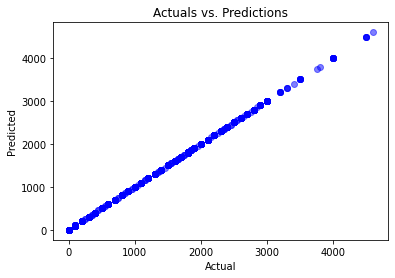

In [15]:
yhat_test = modeling_pipeline.predict(X_test)

plt.plot(y_test, yhat_test, 'bo', alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actuals vs. Predictions')
plt.show()

### Checking Residuals

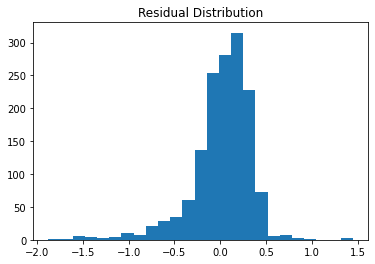

In [16]:
yhat_residuals = y_test - yhat_test

plt.hist(yhat_residuals, bins=25)
plt.title('Residual Distribution')
plt.show()

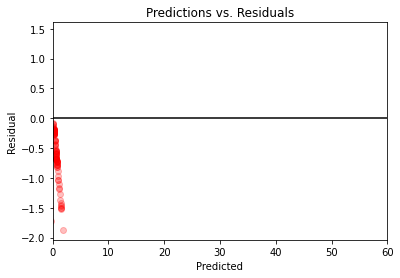

In [17]:
plt.plot(yhat_test, yhat_residuals, 'ro', alpha=0.25)
plt.hlines(0,0,60)
plt.xlim(0,60)
plt.title('Predictions vs. Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

# OLS

In [18]:
def gradientDescent(x, y, theta, alpha, m, numIterations):
    thetaHistory = list()
    
    xTrans = x.transpose()
    costList = list()
    
    for i in range(0, numIterations):
        # data x feature weights = y_hat
        hypothesis = np.dot(x, theta)
        # how far we are off
        loss = hypothesis - y 
        # mse
        cost = np.sum(loss ** 2) / (2 * m)
        costList.append(cost)

        # avg gradient per example
        gradient = np.dot(xTrans, loss) / m 

        # update
        theta = theta - alpha * gradient
        thetaHistory.append(theta)
        
    return thetaHistory, costList

In [19]:
data_pipeline = Pipeline([('data_processing', processing_pipeline)])
data_pipeline.fit(X_training)
gs_training_data = data_pipeline.fit_transform(X_training)

Running the OLS

In [ ]:
import datetime

start_ts = datetime.datetime.now()
betaHistory, costList = gradientDescent(gs_training_data,y_training,
                                        theta=np.zeros(gs_training_data.shape[1]),
                                        alpha=0.01,
                                        m=gs_training_data.shape[0], numIterations=5000)
                                                                 
end_ts = datetime.datetime.now()

print(f'Completed in {end_ts-start_ts}')

### OLS result

In [ ]:

plt.plot(costList)
plt.title(f'Final cost: {costList[-1]:,.2f}', loc='left')
plt.show()

Changes in Beta over the iterations

In [ ]:
from collections import defaultdict
thetas = defaultdict(list)

for i in range(len(betaHistory)):
    for j in range(len(betaHistory[i])):
        thetas[j].append(betaHistory[i][j])
        
thetasD = pd.DataFrame.from_dict(thetas)
thetasD.plot(legend=False)
plt.title('Beta Estimates')
plt.ylabel('Coefficient')
plt.xlabel('Iteration')
plt.show()

Predictions after OLS

In [ ]:
gs_betas = betaHistory[4999]
gs_predictions = np.dot(gs_training_data, gs_betas)

plt.plot(y_training, gs_predictions, 'bo', alpha=0.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Descent Regression Fit on Training Data')
plt.show()

#RIDGE

In [20]:
from sklearn.linear_model import Ridge

modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=0))])
modeling_pipeline_ridge.fit(X_training, y_training)
modeling_pipeline_ridge['ridge'].coef_

array([ 9.23192725e+02,  8.14035932e-02,  1.99984925e-01, ...,
       -2.66577858e-01,  3.25875302e-01,  7.46717527e-01])

In [21]:
modeling_pipeline['lm'].coef_

array([ 9.23253916e+02,  4.26056019e-02,  1.38085050e-01, ...,
       -1.10472571e-02,  4.50100466e-02,  8.37710020e-02])

The coefficients seem to be really close to the regular one except each parameter seems to have much less of an effect in the ridge version. Each of the coefficient are closer to 0 in general.

In [22]:
from collections import defaultdict
alphas = [0, 1, 2, 5, 10, 50]

ridge_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=alph))])
    modeling_pipeline_ridge.fit(X_training, y_training)
    ridge_results['coefficients'][alph] = modeling_pipeline_ridge['ridge'].coef_
    ridge_results['training score'][alph] = modeling_pipeline_ridge.score(X_training, y_training)
    ridge_results['test score'][alph] = modeling_pipeline_ridge.score(X_test, y_test)
    
print('Finished')

Finished


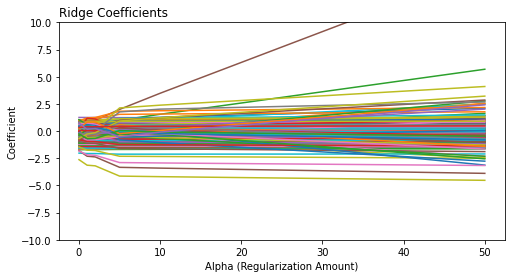

In [23]:
coefficients = pd.DataFrame.from_dict(ridge_results['coefficients'])
coefficients = coefficients.reset_index()
coefficients = coefficients.rename(columns={'index':'coefficient_nbr'})
coefficients = coefficients.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

(
coefficients.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient')
    .plot(figsize=(8,4),legend=False)
)

plt.title('Ridge Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.ylim((-10, 10))
plt.show()

as the alphas rise, the coefficients in each of the models act in their own uniwue way. None of the coefficents seem to go past negative 5 but they are not positively bounded in any way.

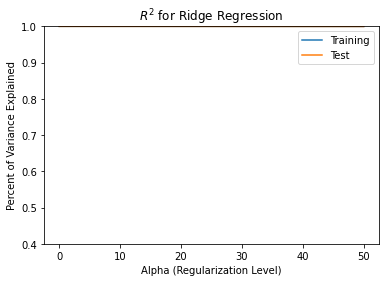

In [24]:
ridge_training_r2 = pd.Series(ridge_results['training score'])
ridge_test_r2 = pd.Series(ridge_results['test score'])

ridge_training_r2.plot()
ridge_test_r2.plot()
plt.title('$R^2$ for Ridge Regression')
plt.legend(['Training','Test'])
plt.xlabel('Alpha (Regularization Level)')
plt.ylabel('Percent of Variance Explained')
plt.ylim(0.4, 1)
plt.show()

I find it interesting that no matter what model i use, the R^2 refuses to show up on the graph

## LASSO

In [ ]:
from sklearn.linear_model import Lasso
from collections import defaultdict

alphas = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]

lasso_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_lasso = Pipeline([('data_processing', processing_pipeline), ('lasso', Lasso(alpha=alph))])
    modeling_pipeline_lasso.fit(X_training, y_training)
    lasso_results['coefficients'][alph] = modeling_pipeline_lasso['lasso'].coef_
    lasso_results['training score'][alph] = modeling_pipeline_lasso.score(X_training, y_training)
    lasso_results['test score'][alph] = modeling_pipeline_lasso.score(X_test, y_test)
    
print('Finished')

Finished


### Lasso Coeffs

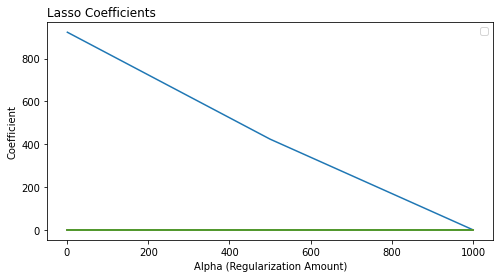

In [ ]:
coefficients = pd.DataFrame.from_dict(lasso_results['coefficients'])
coefficients = coefficients.reset_index()
coefficients = coefficients.rename(columns={'index':'coefficient_nbr'})
coefficients = coefficients.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

coefficients.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient').plot(figsize=(8,4))
plt.title('Lasso Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.legend('')
plt.show()

Lasso changes in R^2

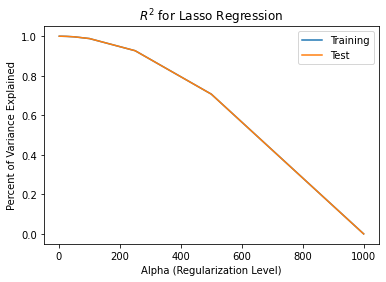

In [ ]:
lasso_training_r2 = pd.Series(lasso_results['training score'])
lasso_test_r2 = pd.Series(lasso_results['test score'])

lasso_training_r2.plot()
lasso_test_r2.plot()
plt.title('$R^2$ for Lasso Regression')
plt.legend(['Training','Test'])
plt.xlabel('Alpha (Regularization Level)')
plt.ylabel('Percent of Variance Explained')
plt.show()

Answer the following:
* Does this help or hurt performance?
  * Lasso seems to help the performance. the training line is directly on top of the test line. None of the other techniques has the training and test lines right on top of each other.
* What happens as you increase the regularization strength? 
  * As I increase the regularization strength, the percent of varience drops.
* How do the coefficients compare with OLS? 
  * The coefficients seem to get closer to each other more quickly than in OLS
